In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
# from keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import time

%matplotlib inline

image_size = 224
batch_size = 32

# 1. Read train and test pictures


In [2]:
# folders with train dir & val dir
train_dir = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/train'
test_dir = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/val'
input_shape = (image_size, image_size, 3)

#2. Generate train and test datasets


*   Data augmentation (different types) is applied to train
*   A distribution count is performed on both datasets



In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')
train_generator.class_indices

train_reversed_classes = {value : key for (key, value) in train_generator.class_indices.items()}
unique, counts = np.unique(train_generator.classes, return_counts=True)

for i in unique:
  print(train_reversed_classes[i] + " : " + str(counts[i]))

Found 2754 images belonging to 5 classes.
daisy : 507
dandelion : 587
roses : 513
sunflowers : 560
tulips : 587


In [4]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')
test_generator.class_indices

test_reversed_classes = {value : key for (key, value) in test_generator.class_indices.items()}
unique, counts = np.unique(test_generator.classes, return_counts=True)

for i in unique:
  print(test_reversed_classes[i] + " : " + str(counts[i]))

Found 683 images belonging to 5 classes.
daisy : 126
dandelion : 145
roses : 128
sunflowers : 139
tulips : 145


# 3. Load imagenet weigths and retrain adding some layers at the end


1.   Middle activation is relu function but last layer activation is softmax in order to get normalized probabilities
2.   The model is then retrained in 40 epochs with 40 substeps (v1 and v2) and in 100 epochs with 50 substeps (v3)
3.   Only the best iteration is saved during the training
4.   If the model does not improve in 10 epochs, the learning rate is reduced by 0.5 





In [5]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
pretrained_model.trainable = False

In [6]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flower_detector_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 50

start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=100,
    verbose=2)
end = time.time()
print("Elapsed time: " + str(end - start) + " seconds")

Epoch 1/100
50/50 - 29s - loss: 1.0995 - accuracy: 0.6356 - val_loss: 1.2247 - val_accuracy: 0.6562

Epoch 00001: val_loss improved from inf to 1.22469, saving model to /content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flower_detector_best.h5
Epoch 2/100
50/50 - 22s - loss: 0.7638 - accuracy: 0.7281 - val_loss: 0.6634 - val_accuracy: 0.7437

Epoch 00002: val_loss improved from 1.22469 to 0.66337, saving model to /content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flower_detector_best.h5
Epoch 3/100
50/50 - 21s - loss: 0.7011 - accuracy: 0.7513 - val_loss: 0.4905 - val_accuracy: 0.8000

Epoch 00003: val_loss improved from 0.66337 to 0.49054, saving model to /content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flower_detector_best.h5
Epoch 4/100
50/50 - 22s - loss: 0.5991 - accuracy: 0.7892 - val_loss: 0.5762 - val_accuracy: 0.7812

Epoch 00004: val_loss did not improve from 0.49054
Epoch 5/100
50/50 - 21s - loss: 0.6009 - accuracy: 0.7726 - val_loss: 1.1023 - val_accuracy: 0.6

# 4. Plot performance and final accuracy

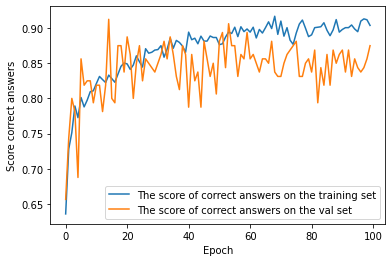

In [8]:
plt.plot(history.history['accuracy'], label='The score of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The score of correct answers on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

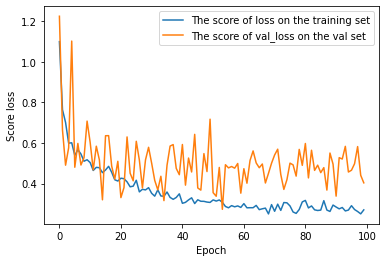

In [9]:
plt.plot(history.history['loss'], label='The score of loss on the training set')
plt.plot(history.history['val_loss'], label='The score of val_loss on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score loss')
plt.legend()
plt.show()

In [10]:
print("The final model has an accuracy on test pictures of " + str(np.max(history.history['val_accuracy'])) + " reached in epoch " + str(1+np.argmax(history.history['val_accuracy'])))

The final model has an accuracy on test pictures of 0.9125000238418579 reached in epoch 15


# 5. Load final best model and test it with random pics



In [11]:
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flower_detector_best.h5')

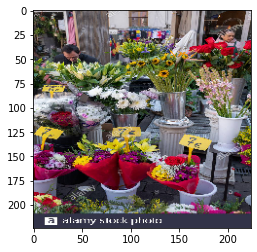

I'm 47.79541194438934% the photo is a tulips


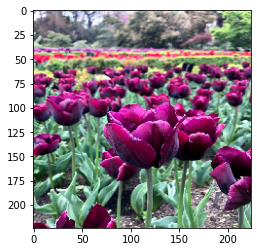

I'm 99.51500296592712% the photo is a tulips


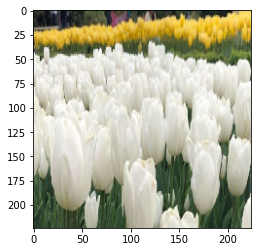

I'm 99.93519186973572% the photo is a tulips


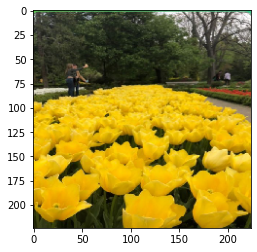

I'm 94.83069777488708% the photo is a tulips


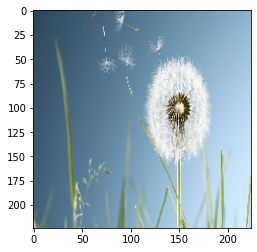

I'm 99.49122667312622% the photo is a dandelion


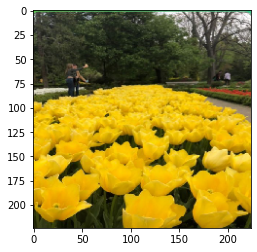

I'm 94.83069777488708% the photo is a tulips


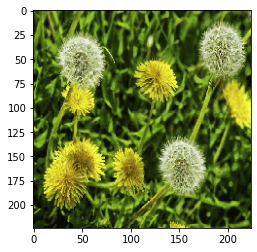

I'm 72.26060032844543% the photo is a sunflowers


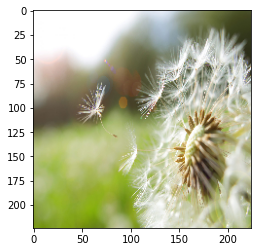

I'm 81.67764544487% the photo is a dandelion


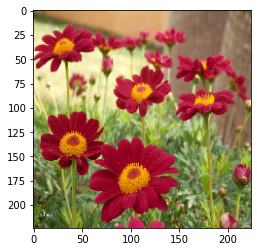

I'm 74.98617172241211% the photo is a sunflowers


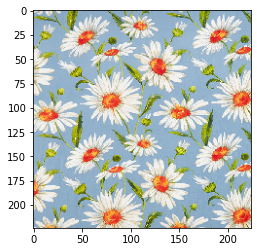

I'm 99.36466217041016% the photo is a daisy


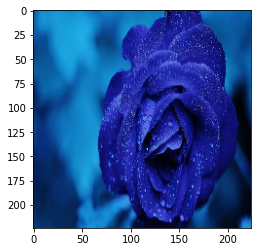

I'm 99.91750121116638% the photo is a roses


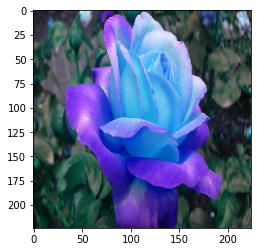

I'm 60.547178983688354% the photo is a roses


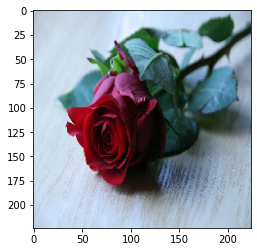

I'm 99.80400204658508% the photo is a roses


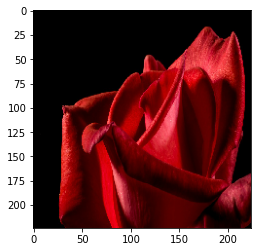

I'm 95.94812393188477% the photo is a roses


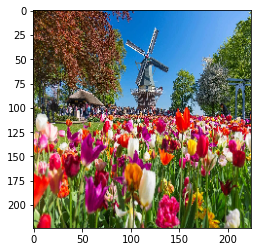

I'm 93.45542192459106% the photo is a tulips


In [15]:

img_path1 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/mercado-de-las-flores-plaza-tirso-de-molina-madrid-espana-2amrnny.jpg'
img_path2 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/mis_tulipanes_jardin_botanico_madrid_1.jpeg'
img_path3 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/mis_tulipanes_jardin_botanico_madrid_2.jpeg'
img_path4 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/mis_tulipanes_jardin_botanico_madrid_3.jpeg'
img_path5 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/diente_leon.jpg'
img_path6 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/diente_leon1.png'
img_path7 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/diente_leon2.jpg'
img_path8 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/margaritas_rojas.jpg'
img_path9 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/margaritas_tela.jpg'
img_path10 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/rosa_azul.jpg'
img_path11 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/rosa_neon.jpg'
img_path12 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/rosa_normal.jpg'
img_path13 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/rosa_zoom.jpg'
img_path14 = '/content/drive/MyDrive/ColabNotebooks/seedtag_codetest/flowers/tulipanes_holanda.jpg'

list_paths = [img_path1,img_path2,img_path3,img_path4,img_path5,img_path4,img_path6,img_path7,img_path8,img_path9,img_path10,img_path11,img_path12,img_path13,img_path14]

for img_path in list_paths: 
  img = image.load_img(img_path, target_size=(image_size, image_size))
  plt.imshow(img)
  plt.show()

  x = image.img_to_array(img) / 255
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x)

  print("I'm " + str(np.max(prediction)*100) + "% the photo is a " + test_reversed_classes[int(np.argmax(prediction, axis = 1))])